## 1. Imports and Setup ##

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F 
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy.random as random
from timm.models.layers import trunc_normal_, DropPath


## 2.Load CIFAR-100 Dataset & Data Preprocessing ##

In [3]:
NUM_TRAIN = 49000
batch_size= 64

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.

#===========================================================================#
# You should try changing the transform for the training data to include    #
# data augmentation such as RandomCrop and HorizontalFlip                    #
# when running the final part of the notebook where you have to achieve     #
# as high accuracy as possible on CIFAR-100.                                #
# Of course you will have to re-run this block for the effect to take place #
#===========================================================================#
train_transform = transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-100
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar100_train = dset.CIFAR100('./datasets/cifar100', train=True, download=True,
                             transform=train_transform)
loader_train = DataLoader(cifar100_train, batch_size=batch_size, num_workers=2,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar100_val = dset.CIFAR100('./datasets/cifar100', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar100_val, batch_size=batch_size, num_workers=2, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar100_test = dset.CIFAR100('./datasets/cifar100', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar100_test, batch_size=batch_size, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## 3.Device Setup ##

In [4]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


## 4.Utility Functions ##

In [5]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = model.to(device)  # Move the model to the GPU (if available)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: The accuracy of the model
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                check_accuracy(loader_val, model)
                print()
    return check_accuracy(loader_val, model)

## 5. LayerNorm and GRN classes ##

In [10]:

            
class LayerNorm(nn.Module):
    """ LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

class GRN(nn.Module):
    """ GRN (Global Response Normalization) layer
    """
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        Gx = torch.norm(x, p=2, dim=(1,2), keepdim=True)
        Nx = Gx / (Gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * Nx) + self.beta + x

## 6. ConvNeXtV2 Model With LayerNorm ##

In [11]:


class Block(nn.Module):
    """ ConvNeXtV2 Block.
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
    """
    def __init__(self, dim, drop_path=0.):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.grn = GRN(4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXtV2(nn.Module):
    """ ConvNeXt V2
        
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 100
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=100, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], 
                 drop_path_rate=0., head_init_scale=1.
                 ):
        super().__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x



## 7. ConvNeXtV2 Model Variations ##

In [13]:
def convnextv2_atto(**kwargs):
    model = ConvNeXtV2(depths=[2, 2, 6, 2], dims=[40, 80, 160, 320], **kwargs)
    return model


def convnextv2_nano(**kwargs):
    model = ConvNeXtV2(depths=[2, 2, 8, 2], dims=[80, 160, 320, 640], **kwargs)
    return model
    
def convnextv2_tiny(**kwargs):
    model = ConvNeXtV2(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    return model


def convnextv2_base(**kwargs):
    model = ConvNeXtV2(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], **kwargs)
    return model

def convnextv2_huge(**kwargs):
    model = ConvNeXtV2(depths=[3, 3, 27, 3], dims=[352, 704, 1408, 2816], **kwargs)
    return model

## Test 1. Base Model and RAdam Optimizer ##

In [8]:
model = None
optimizer = None

model = convnextv2_base()
optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
print (optimizer)
print_every = 700
train(model, optimizer, epochs=50)

RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    weight_decay: 0
)
Epoch 0, Iteration 700, loss = 3.6862
Checking accuracy on validation set
Got 135 / 1000 correct (13.50)

Epoch 1, Iteration 700, loss = 3.3863
Checking accuracy on validation set
Got 209 / 1000 correct (20.90)

Epoch 2, Iteration 700, loss = 2.9747
Checking accuracy on validation set
Got 262 / 1000 correct (26.20)

Epoch 3, Iteration 700, loss = 2.4777
Checking accuracy on validation set
Got 291 / 1000 correct (29.10)

Epoch 4, Iteration 700, loss = 2.4003
Checking accuracy on validation set
Got 309 / 1000 correct (30.90)

Epoch 5, Iteration 700, loss = 2.0568
Checking accuracy on validation set
Got 337 / 1000 correct (33.70)

Epoch 6, Iteration 700, loss = 1.6943
Checking accuracy on validation set
Got 337 / 1000 correct (33.70)

Epoch 7, Iteration 700, loss = 1.1590
Checking accuracy on validation set
Got 3

0.34

## Test 2. Base Model and Mutiple Optimizers ##

In [45]:
model = None
optimizer1 = None
optimizer2 = None
optimizer3 = None

model = convnextv2_base()




optimizer1 = optim.SGD(model.parameters(), lr=0.001,momentum=0.9, nesterov=True)
optimizer2 = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
optimizer3 = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)





print_every = 700
train(model, optimizer1, epochs=20)
print_every = 700
train(model, optimizer2, epochs=20)
print_every = 700
train(model, optimizer3, epochs=20)   

Epoch 0, Iteration 700, loss = 2.9780
Checking accuracy on validation set
Got 195 / 1000 correct (19.50)

Epoch 1, Iteration 700, loss = 3.2800
Checking accuracy on validation set
Got 260 / 1000 correct (26.00)

Epoch 2, Iteration 700, loss = 2.5328
Checking accuracy on validation set
Got 270 / 1000 correct (27.00)

Epoch 3, Iteration 700, loss = 2.2742
Checking accuracy on validation set
Got 274 / 1000 correct (27.40)

Epoch 4, Iteration 700, loss = 2.0230
Checking accuracy on validation set
Got 288 / 1000 correct (28.80)

Epoch 5, Iteration 700, loss = 1.9398
Checking accuracy on validation set
Got 300 / 1000 correct (30.00)

Epoch 6, Iteration 700, loss = 1.1959
Checking accuracy on validation set
Got 294 / 1000 correct (29.40)

Epoch 7, Iteration 700, loss = 0.7514
Checking accuracy on validation set
Got 275 / 1000 correct (27.50)

Epoch 8, Iteration 700, loss = 0.3757
Checking accuracy on validation set
Got 297 / 1000 correct (29.70)

Epoch 9, Iteration 700, loss = 0.2019
Checking

0.272

## Graph 1. Base Model and Mutiple Optimizer ##

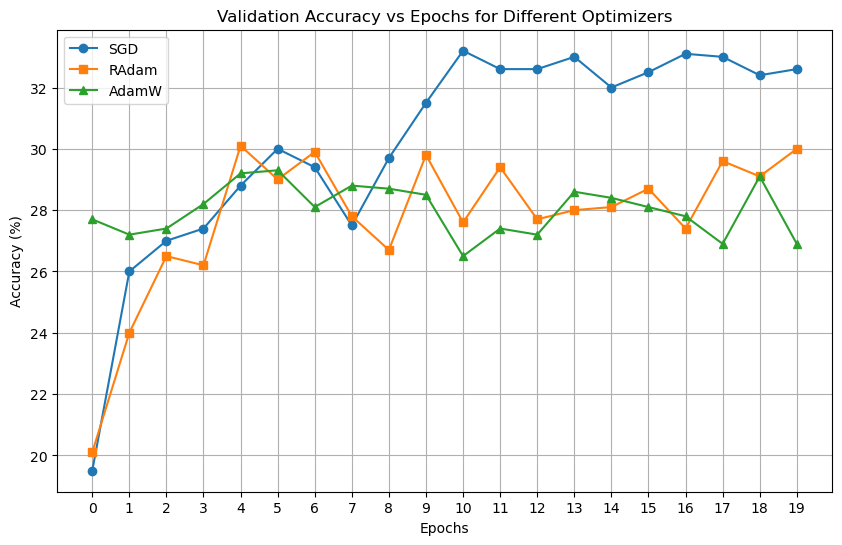

In [12]:
import matplotlib.pyplot as plt

# Data for each optimizer
epochs = list(range(20))  # Epochs from 0 to 19

# SGD Optimizer
sgd_accuracies = [
    19.50, 26.00, 27.00, 27.40, 28.80, 30.00, 29.40, 27.50, 29.70, 31.50,
    33.20, 32.60, 32.60, 33.00, 32.00, 32.50, 33.10, 33.00, 32.40, 32.60
]

# RAdam Optimizer
radam_accuracies = [
    20.10, 24.00, 26.50, 26.20, 30.10, 29.00, 29.90, 27.80, 26.70, 29.80,
    27.60, 29.40, 27.70, 28.00, 28.10, 28.70, 27.40, 29.60, 29.10, 30.00
]

# AdamW Optimizer
adamw_accuracies = [
    27.70, 27.20, 27.40, 28.20, 29.20, 29.30, 28.10, 28.80, 28.70, 28.50,
    26.50, 27.40, 27.20, 28.60, 28.40, 28.10, 27.80, 26.90, 29.10, 26.90
]

# Plotting the data
plt.figure(figsize=(10, 6))

# SGD Plot
plt.plot(epochs, sgd_accuracies, label='SGD', marker='o')

# RAdam Plot
plt.plot(epochs, radam_accuracies, label='RAdam', marker='s')

# AdamW Plot
plt.plot(epochs, adamw_accuracies, label='AdamW', marker='^')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy vs Epochs for Different Optimizers')
plt.xticks(epochs)  # Show all epoch numbers on the x-axis
plt.legend()  # Show legend
plt.grid(True)  # Add grid for better readability

# Show the plot
plt.show()

## Cache Release & Memory Reclaim ##

In [31]:
torch.cuda.empty_cache() 

import gc
gc.collect()



0

## Test 3. Mutiple Models and RAdam Optimizer ##

In [ ]:
model = None
optimizer = None


models = {
    'convnextv2_atto': convnextv2_atto,
    'convnextv2_nano': convnextv2_nano,
    'convnextv2_base': convnextv2_base
}



for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    print_every = 700
    train(model, optimizer, epochs=50)



Training convnextv2_atto...
Epoch 0, Iteration 700, loss = 3.4492
Checking accuracy on validation set
Got 171 / 1000 correct (17.10)

Epoch 1, Iteration 700, loss = 3.2734
Checking accuracy on validation set
Got 233 / 1000 correct (23.30)

Epoch 2, Iteration 700, loss = 2.6952
Checking accuracy on validation set
Got 265 / 1000 correct (26.50)

Epoch 3, Iteration 700, loss = 2.5212
Checking accuracy on validation set
Got 297 / 1000 correct (29.70)

Epoch 4, Iteration 700, loss = 2.6449
Checking accuracy on validation set
Got 298 / 1000 correct (29.80)

Epoch 5, Iteration 700, loss = 2.0988
Checking accuracy on validation set
Got 316 / 1000 correct (31.60)

Epoch 6, Iteration 700, loss = 2.2373
Checking accuracy on validation set
Got 320 / 1000 correct (32.00)

Epoch 7, Iteration 700, loss = 1.8152
Checking accuracy on validation set
Got 312 / 1000 correct (31.20)

Epoch 8, Iteration 700, loss = 1.2810
Checking accuracy on validation set
Got 321 / 1000 correct (32.10)

Epoch 9, Iteration

## Graph 2. Mutiple Models and RAdam Optimizer ##

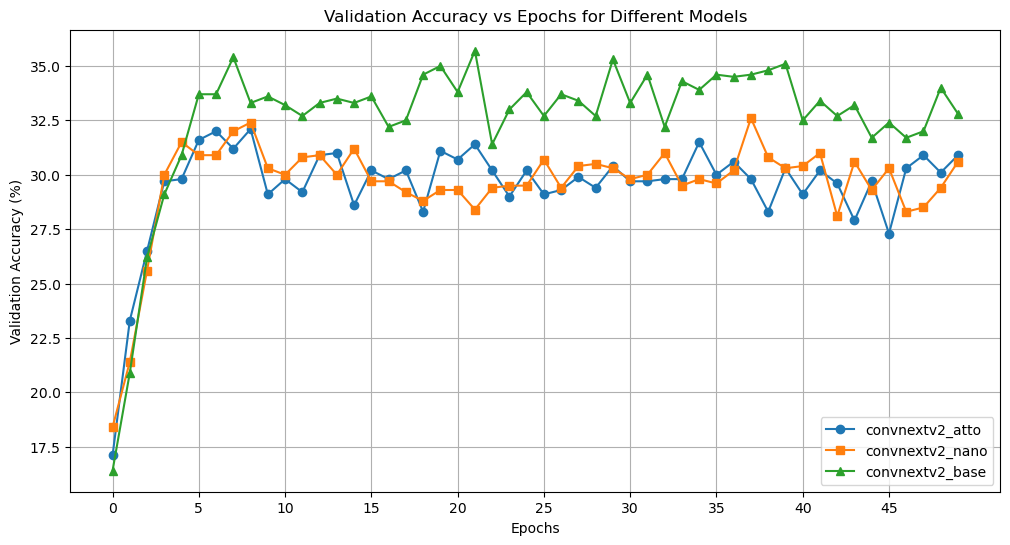

In [13]:
import matplotlib.pyplot as plt

# Data for each model
epochs = list(range(50))  # Epochs from 0 to 49

# convnextv2_atto
atto_accuracies = [
    17.10, 23.30, 26.50, 29.70, 29.80, 31.60, 32.00, 31.20, 32.10, 29.10,
    29.80, 29.20, 30.90, 31.00, 28.60, 30.20, 29.80, 30.20, 28.30, 31.10,
    30.70, 31.40, 30.20, 29.00, 30.20, 29.10, 29.30, 29.90, 29.40, 30.40,
    29.70, 29.70, 29.80, 29.80, 31.50, 30.00, 30.60, 29.80, 28.30, 30.30,
    29.10, 30.20, 29.60, 27.90, 29.70, 27.30, 30.30, 30.90, 30.10, 30.90
]

# convnextv2_nano
nano_accuracies = [
    18.40, 21.40, 25.60, 30.00, 31.50, 30.90, 30.90, 32.00, 32.40, 30.30,
    30.00, 30.80, 30.90, 30.00, 31.20, 29.70, 29.70, 29.20, 28.80, 29.30,
    29.30, 28.40, 29.40, 29.50, 29.50, 30.70, 29.40, 30.40, 30.50, 30.30,
    29.80, 30.00, 31.00, 29.50, 29.80, 29.60, 30.20, 32.60, 30.80, 30.30,
    30.40, 31.00, 28.10, 30.60, 29.30, 30.30, 28.30, 28.50, 29.40, 30.60
]

# convnextv2_base
base_accuracies = [
    16.40, 20.90, 26.20, 29.10, 30.90, 33.70, 33.70, 35.40, 33.30, 33.60,
    33.20, 32.70, 33.30, 33.50, 33.30, 33.60, 32.20, 32.50, 34.60, 35.00,
    33.80, 35.70, 31.40, 33.00, 33.80, 32.70, 33.70, 33.40, 32.70, 35.30,
    33.30, 34.60, 32.20, 34.30, 33.90, 34.60, 34.50, 34.60, 34.80, 35.10,
    32.50, 33.40, 32.70, 33.20, 31.70, 32.40, 31.70, 32.00, 34.00, 32.80
]

# Plotting the data
plt.figure(figsize=(12, 6))

# convnextv2_atto Plot
plt.plot(epochs, atto_accuracies, label='convnextv2_atto', marker='o')

# convnextv2_nano Plot
plt.plot(epochs, nano_accuracies, label='convnextv2_nano', marker='s')

# convnextv2_base Plot
plt.plot(epochs, base_accuracies, label='convnextv2_base', marker='^')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy vs Epochs for Different Models')
plt.xticks(range(0, 50, 5))  # Show epochs at intervals of 5
plt.legend()  # Show legend
plt.grid(True)  # Add grid for better readability

# Show the plot
plt.show()

## Test 4. Tiny Model and RAdam Optimizer ##
**ConvNextV2 model with LayerNorm** 

In [39]:
model = None
optimizer = None

model = convnextv2_tiny()
optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
print (optimizer)
print_every = 700
train(model, optimizer, epochs=20)

RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    weight_decay: 0
)
Epoch 0, Iteration 700, loss = 3.5167
Checking accuracy on validation set
Got 185 / 1000 correct (18.50)

Epoch 1, Iteration 700, loss = 3.3130
Checking accuracy on validation set
Got 206 / 1000 correct (20.60)

Epoch 2, Iteration 700, loss = 2.4911
Checking accuracy on validation set
Got 267 / 1000 correct (26.70)

Epoch 3, Iteration 700, loss = 2.4988
Checking accuracy on validation set
Got 302 / 1000 correct (30.20)

Epoch 4, Iteration 700, loss = 2.2199
Checking accuracy on validation set
Got 307 / 1000 correct (30.70)

Epoch 5, Iteration 700, loss = 2.2537
Checking accuracy on validation set
Got 318 / 1000 correct (31.80)

Epoch 6, Iteration 700, loss = 1.5328
Checking accuracy on validation set
Got 312 / 1000 correct (31.20)

Epoch 7, Iteration 700, loss = 1.1396
Checking accuracy on validation set
Got 3

0.31

## 8. ConvNeXtV2 Model With Dynamic Tanh (Replacing LayerNorm) ##

In [6]:
# Dynamic Tanh Layer
class DynamicTanh(nn.Module):
    def __init__(self, normalized_shape, channels_last, alpha_init_value=0.5):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.alpha_init_value = alpha_init_value
        self.channels_last = channels_last

        self.alpha = nn.Parameter(torch.ones(1) * alpha_init_value)
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        x = torch.tanh(self.alpha * x)
        if self.channels_last:
            x = x * self.weight + self.bias
        else:
            x = x * self.weight[:, None, None] + self.bias[:, None, None]
        return x

    def extra_repr(self):
        return f"normalized_shape={self.normalized_shape}, alpha_init_value={self.alpha_init_value}, channels_last={self.channels_last}"

# GRN Layer
class GRN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        Gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)
        Nx = Gx / (Gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * Nx) + self.beta + x

# ConvNeXt Block with Dynamic Tanh
class Block(nn.Module):
    def __init__(self, dim, drop_path=0.001):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = DynamicTanh(normalized_shape=dim, channels_last=True)  # Replaced LayerNorm with DyT
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.grn = GRN(4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)  # Convert to channels_last format
        x = self.norm(x)  # Apply Dynamic Tanh
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2)  # Convert back to channels_first format
        x = input + self.drop_path(x)
        return x

# ConvNeXtV2 Model
class ConvNeXtV2n(nn.Module):
    def __init__(self, in_chans=3, num_classes=100, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., head_init_scale=1.):
        super().__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList()
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            DynamicTanh(normalized_shape=dims[0], channels_last=False)  # Replaced LayerNorm with DyT
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                DynamicTanh(normalized_shape=dims[i], channels_last=False),  # Replaced LayerNorm with DyT
                nn.Conv2d(dims[i], dims[i + 1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList()
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = DynamicTanh(normalized_shape=dims[-1], channels_last=True)  # Replaced LayerNorm with DyT
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1]))  # Global average pooling

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x



## Test 5. ConvNeXtV2 Tiny Model and RAdam Optimizer ##
**ConvNextV2 model with Dynamic Tanh** 

In [44]:
# Model instantiation and training with dynamic TanH instead of LayerNorm
model = ConvNeXtV2n()
optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
print_every = 700
train(model, optimizer, epochs=20)

Epoch 0, Iteration 700, loss = 3.5297
Checking accuracy on validation set
Got 127 / 1000 correct (12.70)

Epoch 1, Iteration 700, loss = 3.8230
Checking accuracy on validation set
Got 183 / 1000 correct (18.30)

Epoch 2, Iteration 700, loss = 3.2155
Checking accuracy on validation set
Got 233 / 1000 correct (23.30)

Epoch 3, Iteration 700, loss = 3.2900
Checking accuracy on validation set
Got 242 / 1000 correct (24.20)

Epoch 4, Iteration 700, loss = 2.8875
Checking accuracy on validation set
Got 266 / 1000 correct (26.60)

Epoch 5, Iteration 700, loss = 2.6852
Checking accuracy on validation set
Got 274 / 1000 correct (27.40)

Epoch 6, Iteration 700, loss = 2.0125
Checking accuracy on validation set
Got 277 / 1000 correct (27.70)

Epoch 7, Iteration 700, loss = 2.0691
Checking accuracy on validation set
Got 295 / 1000 correct (29.50)

Epoch 8, Iteration 700, loss = 1.5948
Checking accuracy on validation set
Got 291 / 1000 correct (29.10)

Epoch 9, Iteration 700, loss = 1.0590
Checking

0.298

## Graph 3. LayerNorm vs  Dynamic Tanh in ConvNext ##

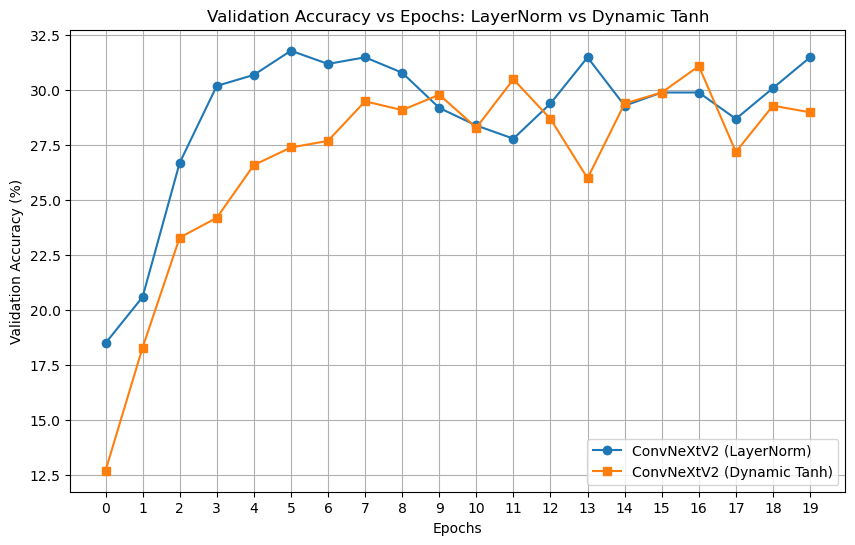

In [47]:
import matplotlib.pyplot as plt

# Data for each model
epochs = list(range(20))  # Epochs from 0 to 19

# ConvNeXtV2 with LayerNorm
layernorm_accuracies = [
    18.50, 20.60, 26.70, 30.20, 30.70, 31.80, 31.20, 31.50, 30.80, 29.20,
    28.40, 27.80, 29.40, 31.50, 29.30, 29.90, 29.90, 28.70, 30.10, 31.50
]

# ConvNeXtV2 with Dynamic Tanh
dytanh_accuracies = [
    12.70, 18.30, 23.30, 24.20, 26.60, 27.40, 27.70, 29.50, 29.10, 29.80,
    28.30, 30.50, 28.70, 26.00, 29.40, 29.90, 31.10, 27.20, 29.30, 29.00
]

# Plotting the data
plt.figure(figsize=(10, 6))

# ConvNeXtV2 with LayerNorm Plot
plt.plot(epochs, layernorm_accuracies, label='ConvNeXtV2 (LayerNorm)', marker='o')

# ConvNeXtV2 with Dynamic Tanh Plot
plt.plot(epochs, dytanh_accuracies, label='ConvNeXtV2 (Dynamic Tanh)', marker='s')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy vs Epochs: LayerNorm vs Dynamic Tanh')
plt.xticks(epochs)  # Show all epoch numbers on the x-axis
plt.legend()  # Show legend
plt.grid(True)  # Add grid for better readability

# Show the plot
plt.show()

## Final Test - ConvNeXtV2 Tiny Model and SGD-Nesterov Optimizer  ##

In [14]:
# Model instantiation and training with dynamic TanH instead of LayerNorm
model = convnextv2_tiny()
#optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9, nesterov=True)
print_every = 700
train(model, optimizer, epochs=20)

Epoch 0, Iteration 700, loss = 3.2714
Checking accuracy on validation set
Got 195 / 1000 correct (19.50)

Epoch 1, Iteration 700, loss = 2.7504
Checking accuracy on validation set
Got 235 / 1000 correct (23.50)

Epoch 2, Iteration 700, loss = 2.7675
Checking accuracy on validation set
Got 252 / 1000 correct (25.20)

Epoch 3, Iteration 700, loss = 2.5517
Checking accuracy on validation set
Got 268 / 1000 correct (26.80)

Epoch 4, Iteration 700, loss = 2.7884
Checking accuracy on validation set
Got 291 / 1000 correct (29.10)

Epoch 5, Iteration 700, loss = 2.3025
Checking accuracy on validation set
Got 291 / 1000 correct (29.10)

Epoch 6, Iteration 700, loss = 2.2628
Checking accuracy on validation set
Got 297 / 1000 correct (29.70)

Epoch 7, Iteration 700, loss = 1.9224
Checking accuracy on validation set
Got 310 / 1000 correct (31.00)

Epoch 8, Iteration 700, loss = 1.6338
Checking accuracy on validation set
Got 300 / 1000 correct (30.00)

Epoch 9, Iteration 700, loss = 1.4549
Checking

0.341